# Different stop detection methods



## Import de la librairie tracklib

In [1]:
# -*- coding: utf-8 -*-
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

    
import matplotlib.pyplot as plt

from tracklib.core.ObsTime import ObsTime
from tracklib.core.ObsCoords import ENUCoords
from tracklib.io.TrackReader import TrackReader
import tracklib.algo.Geometrics as Geometrics

## Présentation de la trace

Présentons tout d'abord la trace sur laquelle les algos de détection des points d'arrêt s'appliqueront. Voir le quickstart aussi qui utilise cette trace.

C'est une trace d'un entrainement de course à pied autour d'une piste. Grosso modo, le coureur faisait des pauses sur place d'une durée d'environ 30 secondes

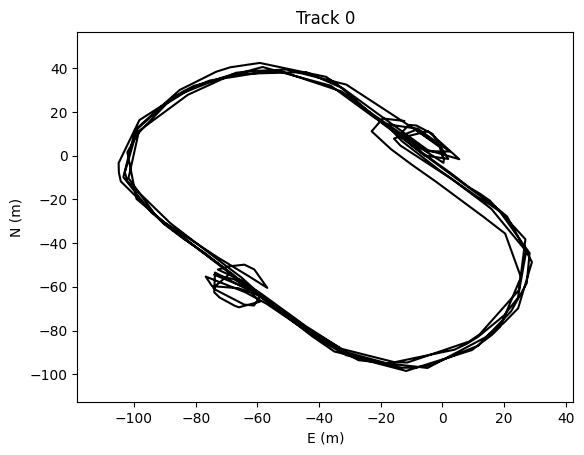

In [2]:
ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
tracks = TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)

# Transformation GEO coordinates to ENU
trace.toENUCoords()

trace.plot()
plt.show()

## st-dbscan

<div class="alert alert-block alert-info">
<b>Reference:</b> <br/>
Birant, D., & Kut, A. (2007). ST-DBSCAN: An algorithm for clustering
spatial–temporal data. Data & Knowledge Engineering, 60(1), 208-221.
</div>

DBSCAN algorithm with three important directions:
1. First, unlike the existing density-based clustering algorithms, our algorithm can cluster spatial–temporal data according to its non-spatial, spatial and temporal attributes. 
2. Second, DBSCAN cannot detect some noise points when clusters of diﬀerent densities exist. Our algorithm solves this problem by assigning to each cluster a density factor.
3. Third, the values of border objects in a cluster may be very diﬀerent than the values of border objects in opposite side, if the non-spatial values of neighbor objects have little diﬀerences and the clusters are adjacent to each other. Our algorithm solves this problem by comparing the average value of a cluster with new coming value.


In [3]:
from tracklib.algo.Segmentation import stdbscan

# Quels paramètres choisir ?
# af_name : t for timestamp
# eps1 = to measure the closeness of two points geographically
# eps2 = to measure the similarity of timestamp values i.e. the proximity timestamp
# MinPts = minimum number of points (a threshold) clustered together
# deltaAF = to prevent the discovering of combined clusters

stdbscan(trace, 't', 15, 30, 5, 1)

print ('New analytical features: ', trace.getListAnalyticalFeatures())

New analytical features:  ['stdbscan', 'noise']


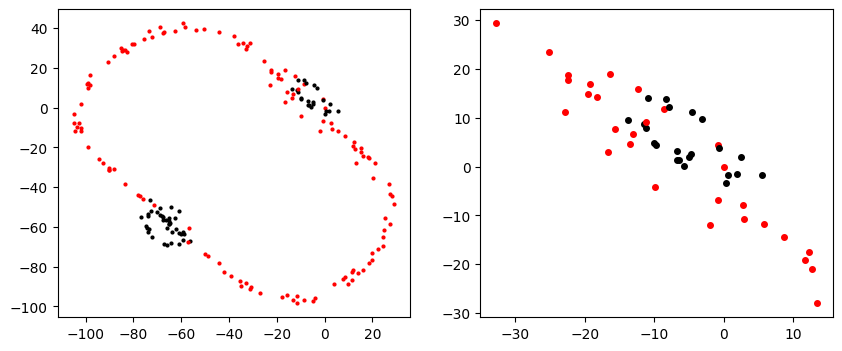

In [4]:
# visualisation des noises
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
for i in range(len(trace)):
    o = trace[i]
    if trace.getObsAnalyticalFeature('noise', i) > 0:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ro', markersize=2)
    else:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=2)


# Dans la zone des pauses
ll = ENUCoords(-40, -40)
ur = ENUCoords(15, 30)
bbox = Geometrics.Rectangle(ll, ur)
ax2 = fig.add_subplot(122)
for i in range(len(trace)):
    o = trace[i]
    if trace.getObsAnalyticalFeature('noise', i) > 0 and bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ro', markersize=4)
    elif bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=4)
plt.show()

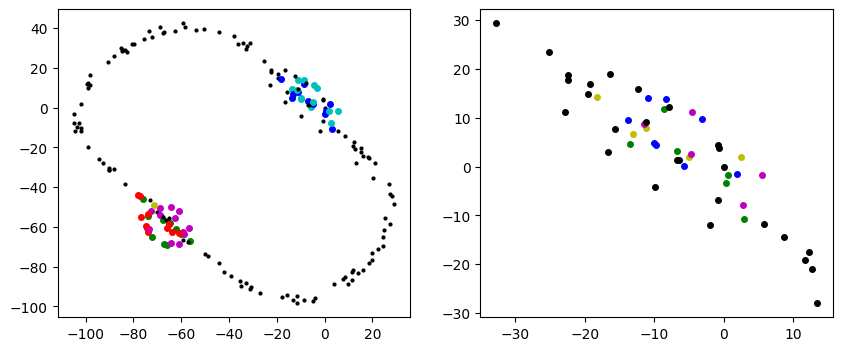

In [5]:
# Les clusters
fig = plt.figure(figsize=(10, 4))
COLORS = ['ro','go','bo','yo','mo','co']
ax1 = fig.add_subplot(121)
for i in range(len(trace)):
    o = trace[i]
    cluster = trace.getObsAnalyticalFeature('stdbscan', i)
    if cluster > 0:
        #print (cluster)
        color = COLORS[cluster%6]
        ax1.plot([o.position.getX()], [o.position.getY()], color, markersize=4)
    else:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=2)

ax2 = fig.add_subplot(122)
cpt = 0
clusterOld = -1
d=dict()
for i in range(len(trace)):
    o = trace[i]
    cluster = trace.getObsAnalyticalFeature('stdbscan', i)
    if cluster > 0 and bbox.contains(o.position):
        if cluster != clusterOld:
            cpt += 1
            d[COLORS[cpt%6]] = []
        color = COLORS[cpt%6]
        ax2.plot([o.position.getX()], [o.position.getY()], color, markersize=4)
        d[color].append(i)
        #ax2.text(o.position.getX()+0.1, o.position.getY()+0.1, str(i))
        clusterOld = cluster
    elif bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=4)
plt.show()

In [6]:
print ('Détail des clusters dans la figure de droite:')
for k in d:
    print (k, d[k])

Détail des clusters dans la figure de droite:
go [29, 30, 32, 34, 35, 36]
bo [67, 68, 69, 70, 71, 72, 73, 74]
yo [109, 110, 112, 113, 114]
mo [147, 149, 150, 151, 152]
